In [1]:
import os
import numpy as np
import networkx as nx
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read all files
files_paths = []
for root, _, files in os.walk("./results"):  # os.walk for recursive 
   for file in files:
       files_paths.append(os.path.join(root, file))  # Construct full path

In [3]:
def read_adjacency_matrix(filename):
    """
    Reads an adjacency matrix .txt file and converts it to a NumPy array.
    
    Args:
        filename: The path to the file containing the adjacency matrix.
    
    Returns:
        A NumPy array representing the adjacency matrix.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()
        
    matrix = []
    for line in lines:
        line = line.strip().split()
        matrix.append(line)
        
    return np.array(matrix, dtype = "int32")

In [9]:
def load_adjacency_matrices(conservative = True, c = 0):
    
    if conservative:
        cons = "conservative"
    else:
        cons = "nconservative"
        
    cx = "c"+str(int(c))
    
    adjacency_matrices = dict()
    for covar in ["raw","mpi_poor"]:
        output = dict()
        regexpr = covar+"_"+cons+"_"+cx
        files = [s for s in files_paths if re.search(regexpr, s)]
        for file in files:
            adj_matrix = read_adjacency_matrix(file)
            country = re.sub(r"^(\./results\\\\)", "", file).split("_")[0][-3:]
            output[country] = adj_matrix
        adjacency_matrices[covar] = output
    
    return adjacency_matrices

In [174]:
adjacency_matrices = load_adjacency_matrices(True, 0)

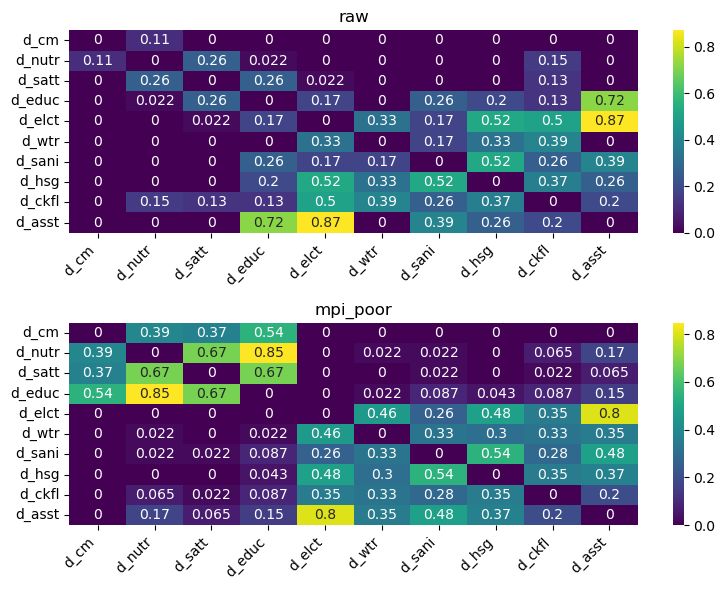

In [175]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # 2x2 grid, adjust figsize as needed
i = 0
for covar in adjacency_matrices:
    all_adj_matrices = list(adjacency_matrices[covar].values())
    edges_proportions = np.sum(all_adj_matrices, axis = 0) / len(all_adj_matrices)
    labels = ['d_cm', 'd_nutr', 'd_satt', 'd_educ', 'd_elct', 'd_wtr', 'd_sani','d_hsg', 'd_ckfl', 'd_asst'] 
    edges_proportions_df = pd.DataFrame(edges_proportions)
    edges_proportions_df.index = labels

    sns.heatmap(edges_proportions_df,ax=axes[i], annot=True, cmap="viridis")
    axes[i].set_xticks(np.arange(len(labels)) + 0.5)  # Center labels on ticks
    axes[i].set_xticklabels(labels, rotation=45, ha='right')  # Set and rotate x labels
    axes[i].set_title(covar) #Set the title for each plot
    i+=1


plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [176]:
def create_graph_from_adjacency_matrix(adj_matrix, directed=False):
    """
    Creates a NetworkX graph from an adjacency matrix.

    Args:
        adj_matrix: A NumPy 2D array representing the adjacency matrix.
        directed: If True, creates a directed graph. Otherwise, creates an undirected graph.

    Returns:
        A NetworkX graph object.  Returns None if the input is not a valid square matrix.
    """

    rows, cols = adj_matrix.shape
    if rows != cols:
        print("Adjacency matrix must be square.")
        return None

    if directed:
        graph = nx.DiGraph()  # Directed graph
    else:
        graph = nx.Graph()  # Undirected graph

    for i in range(rows):
        for j in range(cols):
            if adj_matrix[i, j] != 0:  # Add edge if the corresponding matrix element is non-zero
                if adj_matrix[i, j] == 1 or not isinstance(adj_matrix[i,j],(int, np.integer)): # unweighted
                    graph.add_edge(i, j)
                else: # weighted
                    graph.add_edge(i, j, weight=adj_matrix[i, j]) # Add edge with weight



    return graph

In [177]:
def degrees(x):
    graph = create_graph_from_adjacency_matrix(x)
    degrees = dict(graph.degree())  # Get existing degrees
    all_degrees = {}
    all_nodes = list(range(10))
    for node in all_nodes:
        all_degrees[node] = degrees.get(node, 0)  # Default to 0 if not in graph
    return all_degrees

### Degrees

In [178]:
raw_degrees = None
for x in adjacency_matrices['raw']:
    y = pd.DataFrame.from_dict(degrees(adjacency_matrices['raw'][x]), orient = 'index', columns = [x])
    if raw_degrees is None:
        raw_degrees = y  # First DataFrame, just assign it
    else:
        raw_degrees = raw_degrees.merge(y, left_index=True, right_index=True, how='outer')

In [179]:
raw_degrees

,tgo,sur,tha,zaf,com,srb,pry,bgd,dza,sle,...,ben,moz,mdg,fji,lbr,blz,kgz,arg,gmb,nam
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,2,1,0,0,0,0,1,0,1,1
2,0,0,0,0,0,0,0,1,1,0,...,2,1,1,0,0,0,0,0,1,0
3,1,2,3,0,1,1,2,4,3,2,...,4,2,4,0,2,0,0,1,2,1
4,4,1,2,3,3,1,2,4,3,3,...,4,4,3,2,2,3,0,0,3,3
5,3,0,0,2,0,0,2,1,1,1,...,1,2,1,0,0,0,1,0,1,1
6,1,2,2,2,1,1,3,4,3,1,...,4,2,1,1,2,2,1,2,1,2
7,3,0,2,1,2,0,3,5,1,4,...,2,4,4,0,3,2,0,1,1,2
8,3,0,3,2,2,2,3,4,0,0,...,2,1,1,2,0,3,2,0,3,2
9,3,3,3,2,3,1,3,5,2,3,...,2,3,3,3,3,2,1,2,1,2


In [182]:
# Average degree of each node (indicator)
raw_degrees.mean(axis = 1)

0    0.108696
1    0.543478
2    0.673913
3    1.760870
4    2.586957
5    1.217391
6    1.782609
7    2.195652
8    2.130435
9    2.434783
dtype: float64

In [183]:
raw_degrees

,tgo,sur,tha,zaf,com,srb,pry,bgd,dza,sle,...,ben,moz,mdg,fji,lbr,blz,kgz,arg,gmb,nam
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,2,1,0,0,0,0,1,0,1,1
2,0,0,0,0,0,0,0,1,1,0,...,2,1,1,0,0,0,0,0,1,0
3,1,2,3,0,1,1,2,4,3,2,...,4,2,4,0,2,0,0,1,2,1
4,4,1,2,3,3,1,2,4,3,3,...,4,4,3,2,2,3,0,0,3,3
5,3,0,0,2,0,0,2,1,1,1,...,1,2,1,0,0,0,1,0,1,1
6,1,2,2,2,1,1,3,4,3,1,...,4,2,1,1,2,2,1,2,1,2
7,3,0,2,1,2,0,3,5,1,4,...,2,4,4,0,3,2,0,1,1,2
8,3,0,3,2,2,2,3,4,0,0,...,2,1,1,2,0,3,2,0,3,2
9,3,3,3,2,3,1,3,5,2,3,...,2,3,3,3,3,2,1,2,1,2


In [184]:
sum_degrees = raw_degrees.sum(axis=0)
degrees_by_indicator = raw_degrees.div(sum_degrees, axis=1)
degrees_by_indicator

,tgo,sur,tha,zaf,com,srb,pry,bgd,dza,sle,...,ben,moz,mdg,fji,lbr,blz,kgz,arg,gmb,nam
0,0.000000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.041667,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.083333,0.05,0.000000,0.000,0.000000,0.000000,0.166667,0.000000,0.071429,0.071429
2,0.000000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.035714,0.071429,0.000000,...,0.083333,0.05,0.055556,0.000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000
3,0.055556,0.250,0.1875,0.000000,0.083333,0.166667,0.111111,0.142857,0.214286,0.142857,...,0.166667,0.10,0.222222,0.000,0.166667,0.000000,0.000000,0.166667,0.142857,0.071429
4,0.222222,0.125,0.1250,0.250000,0.250000,0.166667,0.111111,0.142857,0.214286,0.214286,...,0.166667,0.20,0.166667,0.250,0.166667,0.250000,0.000000,0.000000,0.214286,0.214286
5,0.166667,0.000,0.0000,0.166667,0.000000,0.000000,0.111111,0.035714,0.071429,0.071429,...,0.041667,0.10,0.055556,0.000,0.000000,0.000000,0.166667,0.000000,0.071429,0.071429
6,0.055556,0.250,0.1250,0.166667,0.083333,0.166667,0.166667,0.142857,0.214286,0.071429,...,0.166667,0.10,0.055556,0.125,0.166667,0.166667,0.166667,0.333333,0.071429,0.142857
7,0.166667,0.000,0.1250,0.083333,0.166667,0.000000,0.166667,0.178571,0.071429,0.285714,...,0.083333,0.20,0.222222,0.000,0.250000,0.166667,0.000000,0.166667,0.071429,0.142857
8,0.166667,0.000,0.1875,0.166667,0.166667,0.333333,0.166667,0.142857,0.000000,0.000000,...,0.083333,0.05,0.055556,0.250,0.000000,0.250000,0.333333,0.000000,0.214286,0.142857
9,0.166667,0.375,0.1875,0.166667,0.250000,0.166667,0.166667,0.178571,0.142857,0.214286,...,0.083333,0.15,0.166667,0.375,0.250000,0.166667,0.166667,0.333333,0.071429,0.142857


In [207]:
degrees_by_indicator.columns

Index(['tgo', 'sur', 'tha', 'zaf', 'com', 'srb', 'pry', 'bgd', 'dza', 'sle',
       'tun', 'cub', 'gnb', 'mwi', 'gin', 'hnd', 'zmb', 'guy', 'mng', 'tcd',
       'bfa', 'mda', 'eth', 'zwe', 'ner', 'ton', 'civ', 'sdn', 'gab', 'kaz',
       'tza', 'cmr', 'mrt', 'geo', 'kir', 'irq', 'ben', 'moz', 'mdg', 'fji',
       'lbr', 'blz', 'kgz', 'arg', 'gmb', 'nam'],
      dtype='object')

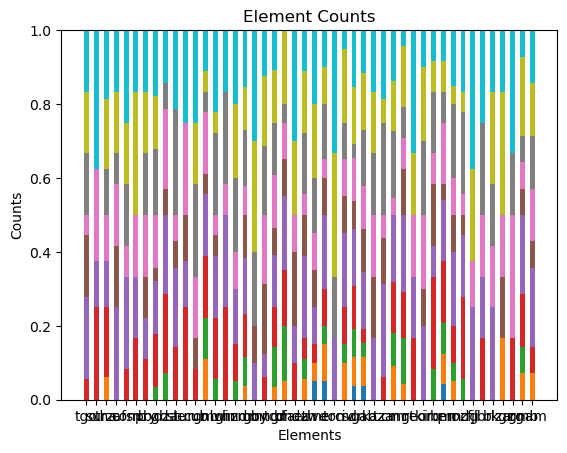

In [209]:
import matplotlib.pyplot as plt

countries = (
    degrees_by_indicator.columns
)
degree_counts = {}
for i in degrees_by_indicator.index:
    degree_counts[str(i)] = np.array(degrees_by_indicator.iloc[i])

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(len(countries))

# Bar plot
for boolean, weight_count in degree_counts.items():
    p = ax.bar(countries, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count
plt.xlabel("Elements")
plt.ylabel("Counts")
plt.title("Element Counts")
plt.show()

In [185]:
mpi_poor_degrees = None
for x in adjacency_matrices['mpi_poor']:
    y = pd.DataFrame.from_dict(degrees(adjacency_matrices['mpi_poor'][x]), orient = 'index', columns = [x])
    if mpi_poor_degrees is None:
        mpi_poor_degrees = y  # First DataFrame, just assign it
    else:
        mpi_poor_degrees = mpi_poor_degrees.merge(y, left_index=True, right_index=True, how='outer')

In [186]:
mpi_poor_degrees

,tgo,sur,tha,zaf,com,srb,pry,bgd,dza,sle,...,ben,moz,mdg,fji,lbr,blz,kgz,arg,gmb,nam
0,3,0,1,1,2,0,0,3,2,3,...,3,1,0,0,3,0,0,2,1,0
1,4,1,2,1,3,0,2,5,2,3,...,4,2,2,1,3,1,1,2,3,3
2,3,0,3,0,2,0,2,5,3,3,...,4,2,2,0,3,0,0,0,2,2
3,3,3,4,2,3,1,3,7,4,3,...,3,3,2,1,3,1,0,2,3,2
4,4,1,1,2,2,1,2,2,2,2,...,4,4,3,2,2,2,0,0,2,3
5,3,0,0,1,1,0,1,1,1,2,...,3,2,4,0,2,0,2,0,1,2
6,1,2,2,2,2,1,2,6,3,1,...,3,3,2,1,1,2,1,2,0,3
7,3,0,2,0,2,0,2,4,0,4,...,4,3,3,0,4,1,1,2,1,2
8,0,0,3,3,2,2,3,3,0,0,...,1,1,0,2,0,3,2,0,1,2
9,4,3,2,2,3,1,1,6,1,3,...,5,3,4,3,3,2,1,2,0,3


In [187]:
# Average degree of each node (indicator)
mpi_poor_degrees.mean(axis = 1)

0    1.304348
1    2.195652
2    1.826087
3    2.456522
4    2.347826
5    1.804348
6    2.021739
7    2.086957
8    1.673913
9    2.586957
dtype: float64

In [188]:
# This is the average degree values of each node (indicators) for the raw indicators and those conditional to multidimensional poverty
pd.concat([raw_degrees.mean(axis = 1),mpi_poor_degrees.mean(axis = 1)], axis = 1)

,0,1
0,0.108696,1.304348
1,0.543478,2.195652
2,0.673913,1.826087
3,1.760870,2.456522
4,2.586957,2.347826
5,1.217391,1.804348
6,1.782609,2.021739
7,2.195652,2.086957
8,2.130435,1.673913
9,2.434783,2.586957


In [189]:
measures = pd.read_excel("./data/Table 1 National Results MPI 2024.xlsx", skiprows=8, index_col=0).iloc[:,[0,1,2,3,4,5,6,7]].dropna()
measures.columns = ["iso","country","region","survey","year","MPI","H","A"]
measures.set_index("iso")

raw = pd.read_excel("./data/Table 1 National Results MPI 2024.xlsx", skiprows=8, index_col=0, sheet_name="1.6 Uncensored Headcounts").iloc[:,[0,1,2,3,4] + list(range(6, 16))].dropna()
raw.columns = ["iso","country","region","survey","year","d_nutr","d_cm","d_educ","d_satt","d_ckfl","d_sani","d_wtr","d_elct","d_hsg","d_asst"]
raw.set_index("iso")
raw

censored = pd.read_excel("./data/Table 1 National Results MPI 2024.xlsx", skiprows=8, index_col=0, sheet_name="1.2 Censored Headcounts").iloc[:,[0,1,2,3,4] + list(range(6, 16))].dropna()
censored.columns = ["iso","country","region","survey","year","d_nutr","d_cm","d_educ","d_satt","d_ckfl","d_sani","d_wtr","d_elct","d_hsg","d_asst"]
censored.set_index("iso")
censored.loc[(censored["country"] == "Rwanda"),:]

,iso,country,region,survey,year,d_nutr,d_cm,d_educ,d_satt,d_ckfl,d_sani,d_wtr,d_elct,d_hsg,d_asst
646,RWA,Rwanda,Sub-Saharan Africa,DHS,2019-2020,23.048536,3.254854,28.911352,7.950016,48.727028,24.896296,34.808714,36.540896,44.436675,36.899645


In [190]:
"rwa" in adjacency_matrices['mpi_poor']

False

## Connected (and disconnected components)

In [191]:
all_cliques = []
for x in ["mwi","gnb"]:
    G = create_graph_from_adjacency_matrix(adjacency_matrices['mpi_poor'][x])
    all_cliques.append(list(nx.connected_components(G)))

In [192]:
all_cliques

[[{0, 1, 2, 3, 4, 5, 6, 7, 9}], [{0, 1, 2, 3, 4, 5, 6, 7, 9}]]

###### 

In [81]:
from collections import Counter

In [82]:
flattened_list = []
for sublist in all_cliques:
    new_sublist = []
    for item in sublist:
        if isinstance(item, list):  # Check if the item is a list
            new_sublist.append(tuple(item)) # Convert to tuple
        else:
            new_sublist.append(item)
    flattened_list.extend(new_sublist)

In [100]:
sorted_list = sorted(flattened_list, key=str) # Sort by string representation to handle tuples
max_cliques_counts = Counter(sorted_list)

In [101]:
counts = {}
for key, value in dict(max_cliques_counts).items():
    counts[str(key)] = value

In [106]:
len(counts)

196

In [96]:
pd.DataFrame.from_dict(counts)

""


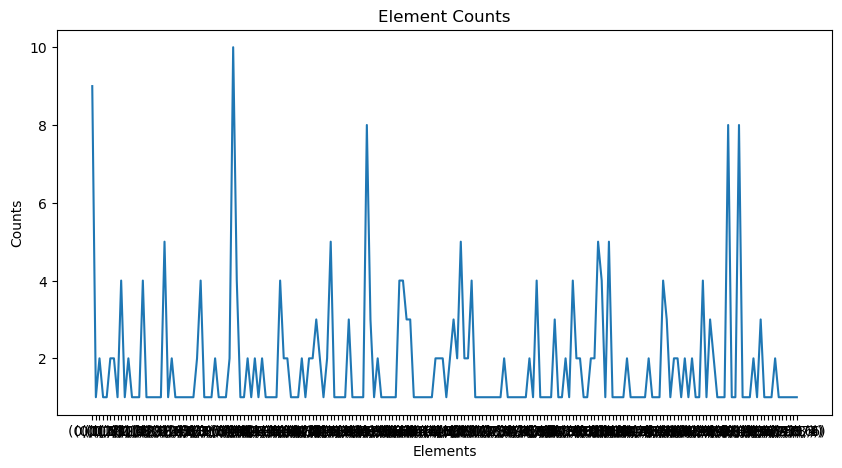

In [107]:
import matplotlib.pyplot as plt
# Extract elements and counts for plotting
elements = list(counts.keys())
counts_values = list(counts.values())

plt.figure(figsize=(10, 5))  # Adjust figure size if needed

# Bar plot
plt.plot(elements, counts_values)
plt.xlabel("Elements")
plt.ylabel("Counts")
plt.title("Element Counts")
plt.show()